In [87]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from glob import glob1
import os
import pandas as pd
import seaborn as sns
color_lst = sns.color_palette("Set2")

try:
    from Detect_peaks import detect_peaks
except Exception as ep:
    print (ep)
    def detect_peaks(y,mph,mpd=10):
        from peakutils import indexes
        return indexes(y, thres=mph, min_dist=mpd) 
    

No module named 'Detect_peaks'


In [88]:
import matplotlib
textsize = 30

matplotlib.rcParams.update({'font.size': textsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'font.family' : 'arial',
          'lines.markersize' : 8,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': textsize*0.8,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': textsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': textsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)


In [89]:
def fasterloadtxt(filename,delimiter=' ',skiprows=0):
    '''
    using pandas to speed up file reading
    '''
    df = pd.read_csv(filename,sep=delimiter,skiprows=skiprows,header=None)
    return df.values#.flatten()


def Lorentzian_fit(x,y,const = True):
    from lmfit.models import LorentzianModel,ConstantModel
    lor = LorentzianModel()
    params = lor.guess(y,x=x)
    con = ConstantModel()
    params += con.guess(y,x=x)
    if not const:
        params['c'].set(value=0,vary=False)
    lor += con
    result = lor.fit(y,params,x=x)
    return result, lor

def double_Lorentzian_fit(x,y,guessparams=None,const=True):
    from lmfit import Model
    def double_lor(x,l0center,l0amplitude,l0fwhm,l1center,l1amplitude,l1fwhm,c):
        lor0 = l0amplitude*(l0fwhm/2)**2/((x-l0center)**2+(l0fwhm/2)**2)
        lor1 = l1amplitude*(l1fwhm/2)**2/((x-l1center)**2+(l1fwhm/2)**2)
        return lor0 + lor1 + c
    mod = Model(double_lor)
    peaks = x[detect_peaks(y,mph=max(y)/3,mpd=5)]
    params = mod.make_params(l0center=peaks[0],l1center=peaks[1],)
    if guessparams is not None:
        try:
            params['l0center'].set(value=guessparams.get('l0center'))
            params['l1center'].set(value=guessparams.get('l1center'))
            params['l0amplitude'].set(value=guessparams.get('l0amplitude'))
            params['l1amplitude'].set(value=guessparams.get('l1amplitude'))
        except Exception as ep:
            print (ep)
            pass
        
    if not const:
        params['c'].set(value=0,vary=False)
    lor += con + lor1
    result = lor.fit(y,params,x=x)
    return result, lor

def load_spectrum_get_center(filename,doublelor = False,isplot=False,params=None):
    data = fasterloadtxt(filename,delimiter='\t',skiprows=1)
    freq_729 = data[:,2]
    population = data[:,4]
    if doublelor:
        result, mod = double_Lorentzian_fit(freq_729,population,params,const=False)
    else:
        result,mod = Lorentzian_fit(freq_729,population,const=False)
    if isplot:
        f = plt.figure()
        ax  =f.add_subplot(111)
        dummyx = np.linspace(min(freq_729),max(freq_729),1000)
        ax.plot(freq_729,population,'-o',color=color_lst[0])
        ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst[1])
        ax.set_xlabel('Freq (MHz)')
        ax.set_ylabel(r'Population, $p_D$')
    return result.params['center'].value,result.params['center'].stderr
def radial_frequency_w_err(center,dcenter,center0,dcenter0):
    radial = center-center0
    dradial = np.sqrt((dcenter)**2+(dcenter0)**2)
    return radial,dradial

In [90]:
directory  = r'Z:\qfc\measurements\trics_data'
subfolder = r'2022-09-13'
folder = [142928,143506,144009,144420,144658,144848,145217,145915,150416]
rf_power = [0,4.117,4.58,3.689,3.282,2.892,2.5205,4.872] #mW
setpoint = [0,758,802,714,670,626,582,830] #mW
data_files = r'PMT1_2.txt'
center = np.zeros(len(folder))
dcenter = np.zeros(len(folder))                 
for j in range(len(folder)):
    filename = os.path.join(directory,subfolder,str(folder[j]),data_files)
    center[j],dcenter[j] = load_spectrum_get_center(filename)
sort_arr = np.argsort(rf_power)
rf_power = np.array(rf_power)[sort_arr] 
center = center[sort_arr]
dcenter= dcenter[sort_arr]
setpoint = np.array(setpoint)[sort_arr]
radial,dradial = radial_frequency_w_err(center[1:],dcenter[1:],center[0],dcenter[0])

[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4
    # data points      = 7
    # variables        = 3
    chi-square         = 5.8194e-05
    reduced chi-square = 1.4548e-05
    Akaike info crit   = -75.8834844
    Bayesian info crit = -76.0457540
[[Variables]]
    c0:  0.73749327 +/- 0.03635195 (4.93%) (init = 0.7374933)
    c1:  0.53311261 +/- 0.02028463 (3.80%) (init = 0.5331126)
    c2: -0.02279286 +/- 0.00272332 (11.95%) (init = -0.02279286)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2) = -0.996
    C(c0, c1) = -0.995
    C(c0, c2) =  0.982
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 7
    # variables        = 2
    chi-square         = 5.6594e-05
    reduced chi-square = 1.1319e-05
    Akaike info crit   = -78.0785678
    Bayesian info crit = -78.1867475
[[Variables]]
    c0: -0.07988145 +/- 0.01076203 (1

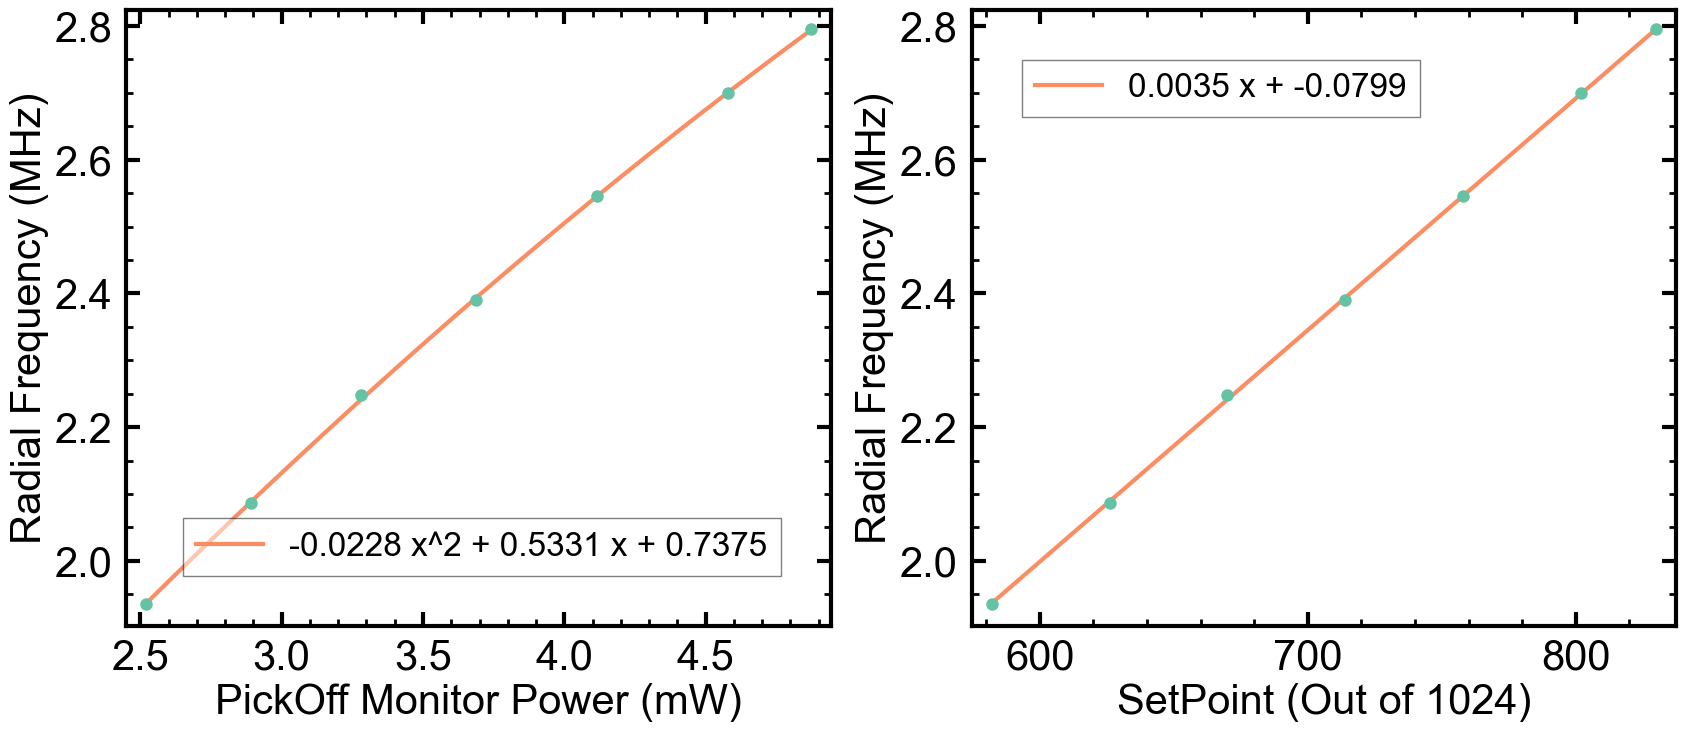

In [86]:
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax.errorbar(rf_power[1:],radial,yerr=dradial,fmt='o',color=color_lst[0])
ax.set_xlabel('PickOff Monitor Power (mW)')
ax.set_ylabel('Radial Frequency (MHz)')


from lmfit.models import LinearModel, PolynomialModel
mod = PolynomialModel(degree=2)
params = mod.guess(radial,x=rf_power[1:])
result = mod.fit(radial,params,x=rf_power[1:])
dummyx = np.linspace(min(rf_power[1:]),max(rf_power[1:]),1000)
ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst[1],
        label='%.4f x^2 + %.4f x + %.4f'%(result.params['c2'].value,result.params['c1'].value,result.params['c0'].value))
print (result.fit_report())
ax.legend(loc='best')

ax1 = f.add_subplot(122)
ax1.errorbar(setpoint[1:],radial,yerr=dradial,fmt='o',color=color_lst[0])
ax1.set_xlabel('SetPoint (Out of 1024)')
ax1.set_ylabel('Radial Frequency (MHz)')


from lmfit.models import LinearModel, PolynomialModel
mod = PolynomialModel(degree=1)
params = mod.guess(radial,x=setpoint[1:])
result = mod.fit(radial,params,x=setpoint[1:])
dummyx = np.linspace(min(setpoint[1:]),max(setpoint[1:]),1000)
ax1.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst[1],label='%.4f x + %.4f'%(result.params['c1'].value,result.params['c0'].value))
ax1.legend(loc='best')
print (result.fit_report())
f.savefig(r'Z:\qfc\Electronics\RF_PID_Box\13092022_RF_Radial.png',dpi=100,bbox_inches='tight',facecolor='white')

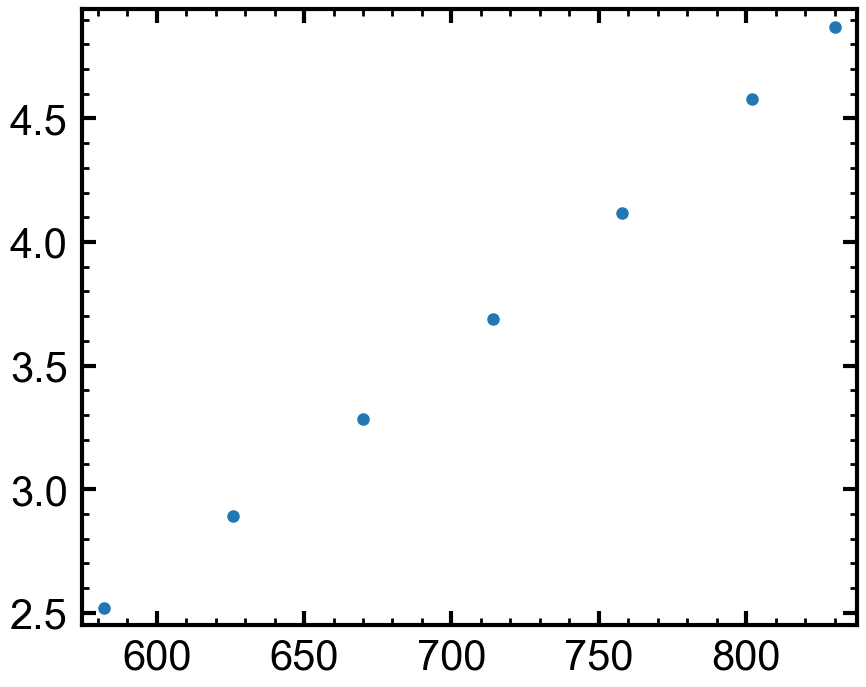

In [95]:
plt.plot(setpoint[1:],rf_power[1:],'o')

In [87]:
import pandas as pd
display = {"Set Point (um)":setpoint[1:],
        "PickOff Monitor Power (mW)":rf_power[1:],
        "Radial Frequency (MHz)":radial,
         "Err (MHz)":dradial}
pd.DataFrame(display)

Set Point (um)  PickOff Monitor Power (mW)  Radial Frequency (MHz)  \
0             582                      2.5205                1.935814   
1             626                      2.8920                2.086877   
2             670                      3.2820                2.247685   
3             714                      3.6890                2.390411   
4             758                      4.1170                2.545945   
5             802                      4.5800                2.699282   
6             830                      4.8720                2.795452   

   Err (MHz)  
0   0.006419  
1   0.004230  
2   0.003991  
3   0.004139  
4   0.004093  
5   0.003855  
6   0.003135

# Fit radial splittings

In [88]:
def double_Lorentzian_fit(x,y,guessparams,const=True):
    from lmfit.models import LorentzianModel,ConstantModel,GaussianModel
    lor = LorentzianModel(prefix='l0')
    lor1 = LorentzianModel(prefix='l1') 
    params = lor.guess(y,x=x) + lor1.guess(y,x=x)
    con = ConstantModel()
    params += con.guess(y,x=x)
    if guessparams is not None:
        try:
            params['l0center'].set(value=guessparams.get('l0center'))
            params['l1center'].set(value=guessparams.get('l1center'))
            params['l0amplitude'].set(value=guessparams.get('l0amplitude'),min=0)
            params['l1amplitude'].set(expr='l0amplitude')
            params['l0sigma'].set(value=guessparams.get('l0sigma'),vary=False)
            params['l1sigma'].set(expr='l0sigma')
        except Exception as ep:
            print (ep)
            pass
    if not const:
        params['c'].set(value=0,vary=False)
    lor += con + lor1
    result = lor.fit(y,params,x=x,weights=(y),nan_policy='omit')
    return result, lor

def load_spectrum_get_center(filename,doublelor = False,isplot=False,params=None):
    data = fasterloadtxt(filename,delimiter='\t',skiprows=1)
    freq_729 = data[:,2]
    population = data[:,4]
    if doublelor:
        result, mod = double_Lorentzian_fit(freq_729,population,params,const=False)
    else:
        result,mod = Lorentzian_fit(freq_729,population,const=False)
    if isplot:
        f = plt.figure()
        ax  =f.add_subplot(111)
        dummyx = np.linspace(min(freq_729),max(freq_729),1000)
        ax.plot(freq_729,population,'-o',color=color_lst[0])
        ax.plot(dummyx,mod.eval(result.params,x=dummyx),color=color_lst[1])
        ax.set_xlabel('Freq (MHz)')
        ax.set_ylabel(r'Population, $p_D$')
    if doublelor:
        return result.params['l0center'].value,result.params['l0center'].stderr,result.params['l1center'].value,result.params['l1center'].stderr
    else:
        return result.params['center'].value,result.params['center'].stderr
def radial_frequency_w_err(center,dcenter,center0,dcenter0):
    radial = center-center0
    dradial = radial*np.sqrt((dcenter/center)**2+(dcenter0/center0)**2)
    return radial,dradial

Splitting = 26.86613 +- 1.46632


Text(0, 0.5, 'Population, $p_D$')

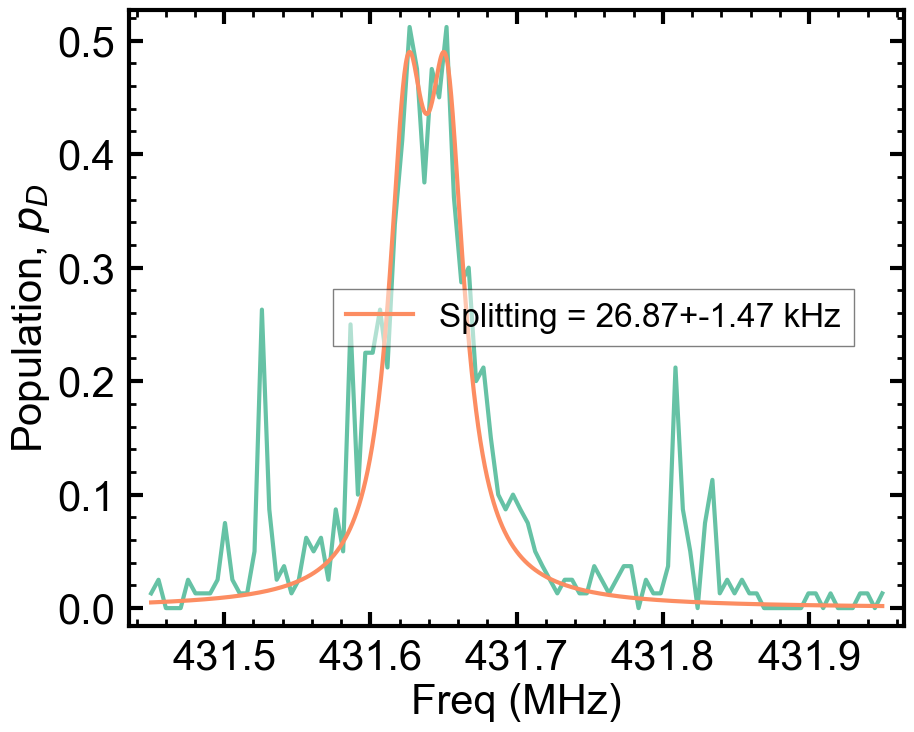

In [104]:
directory  = r'Z:\qfc\measurements\trics_data'
subfolder = r'2022-09-13'
folder = [150416]
rf_power = [4.58] #mW
setpoint = [802] #mW
data_files = r'PMT1_2.txt'
filename = os.path.join(directory,subfolder,str(folder[0]),data_files)
data = fasterloadtxt(filename,delimiter='\t',skiprows=1)
freq_729 = data[:,2]
population = data[:,4]
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(freq_729,population,color=color_lst[0])

params = {'l0center':431.625,'l1center':431.652,'l0amplitude':0.02,'l1amplitude':0.02,'l0sigma':1.5e-2,'l1sigma':1.5e-2}
start = np.searchsorted(freq_729,431.55)
stop = np.searchsorted(freq_729,431.75)
res,mod = double_Lorentzian_fit(freq_729[start:stop],population[start:stop],guessparams=params,const=False)
dummyx = np.linspace(min(freq_729),max(freq_729),1000)
splitting = 1e3*abs(res.params['l1center'].value-res.params['l0center'].value)
dsplitting = 1e3*np.sqrt((res.params['l1center'].stderr)**2+
                               (res.params['l0center'].stderr)**2)
print ('Splitting = {0:.5f} +- {1:.5f}'.format(splitting,dsplitting))

ax.plot(dummyx,mod.eval(res.params,x=dummyx),color=color_lst[1],label='Splitting = {0:.2f}+-{1:.2f} kHz'.format(splitting,dsplitting))
# print(res.fit_report())
ax.legend(loc='best')
ax.set_xlabel('Freq (MHz)')
ax.set_ylabel(r'Population, $p_D$')


# Radial stability

In [92]:
directory  = r'Z:\qfc\measurements\trics_data'
subfolder = r'2022-09-14'
folder = [150426,141601,141745,142138,142324,142551,142743,142926,143252,143434,143615,143838,144033,144215,144403,144925,144552,144744,145107,145316,145525,145734,145918,150142]
data_files = r'PMT1_2.txt'
center = np.zeros(len(folder))
dcenter = np.zeros(len(folder))
time_array = np.zeros(len(folder))
for j in range(len(folder)):
    filename = os.path.join(directory,subfolder,str(folder[j]),data_files)
    data = fasterloadtxt(filename,delimiter='\t',skiprows=1)
    time_array[j] = data[:,0][0]/1e3
    center[j],dcenter[j] = load_spectrum_get_center(filename)

radial,dradial = radial_frequency_w_err(center[1:],dcenter[1:],center[0],dcenter[0])

Text(0.5, 1.0, 'Fluctuation of $1\\sigma=171\\,$Hz')

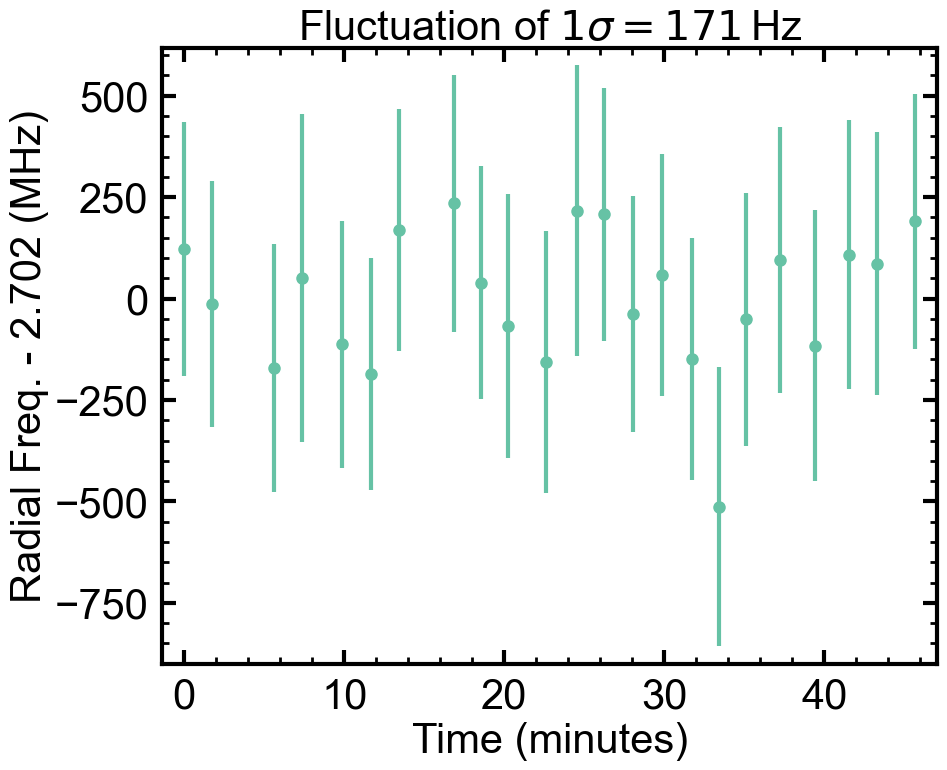

In [93]:
f = plt.figure()
ax = f.add_subplot(111)
ax.errorbar(x=(time_array[1:]-time_array[1])/60,y=1e6*(radial-np.mean(radial)),yerr = dradial*1e6,fmt='o',color=color_lst[0])
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Radial Freq. - %.3f (MHz)'%(-1*np.mean(radial)))
ax.set_title(r'Fluctuation of $1\sigma=%.3g\,$Hz'%(np.std(1e6*(radial))))